In [2]:
import os
import sys
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler

In [3]:
print("Pytorch version:", torch.__version__)

Pytorch version: 2.3.0+cpu


## Loading the images

In [6]:
import torch
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.transforms import transforms, Resize, ToTensor
import rawpy
from PIL import Image
import os

# Define a custom dataset class for DNG images
class DNGDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.lower().endswith('.dng')]
        self.labels = [self.extract_label(fname) for fname in os.listdir(root_dir) if fname.lower().endswith('.dng')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        with rawpy.imread(img_path) as raw:
            img = raw.postprocess()
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label
    
    def extract_label(self, filename):
        label = filename.split('.')[0]  # Assuming label is before the first underscore
        return int(label)  # Convert label to integer if necessary

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
    # transforms.Normalize((0.5,), (0.5,))
])

# Set the path to the dataset folder
dataset_path = r'/home/sj/autoencoder/dataset/day'

# Load the dataset
dataset = DNGDataset(dataset_path, transform=transform)

# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = int((len(dataset) - train_size)/2)
val_size = int(len(dataset) - train_size - test_size)

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Print the number of samples in each set
print(f"Number of training samples: {len(train_set)}")
print(f"Number of testing samples: {len(test_set)}")
print(f"Number of validation samples: {len(val_set)}")

# Optionally, create DataLoaders for the training and testing sets
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=2)

Number of training samples: 56
Number of testing samples: 7
Number of validation samples: 7


In [8]:
# Print a batch of images to verify
for images, labels in train_loader:
    print("training dataset batch shape", images.shape, labels.shape)
    break

for images, labels in test_loader:
    print("testing dataset batch shape", images.shape, labels.shape)
    break

for images, labels in val_loader:
    print("validation dataset batch shape", images.shape, labels.shape)
    break

training dataset batch shape torch.Size([32, 3, 256, 256]) torch.Size([32])
testing dataset batch shape torch.Size([7, 3, 256, 256]) torch.Size([7])
validation dataset batch shape torch.Size([7, 3, 256, 256]) torch.Size([7])


(3024, 4032, 3)


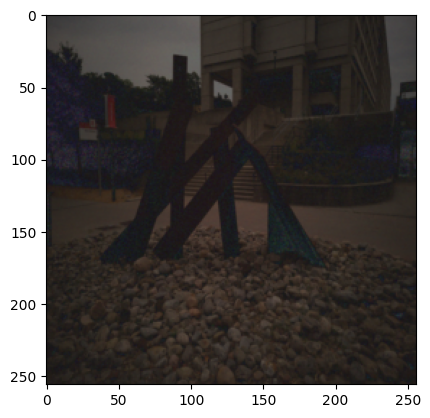

In [11]:
import matplotlib.pyplot as plt

def noisy_image(src_image, fix_exp=None, dst_iso=None, darkness_factor=0.4):
    image = src_image.copy()

    if fix_exp is not None:
        # update image exposure to match target ISO before synthesizing noise, then re-scale it back later
        image_fix_exp = np.round(image.astype(np.float) * fix_exp).astype(np.uint32)
    else:
        image_fix_exp = None

    # if target ISO is not specified, select a random value
    if dst_iso is None:
        dst_iso = 819200

    noise_params = {50: (0.0008, 0.0008), 100: (0.0016, 0.0016), 200: (0.0032, 0.0032), 400: (0.0064, 0.0064),
                    800: (0.0128, 0.0128), 1600: (0.0256, 0.0256), 3200: (0.0512, 0.0512), 6400: (0.1024, 0.1024),
                    12800: (0.2048, 0.2048), 25600: (0.4096, 0.4096), 51200: (0.8192, 0.8192), 102400: (1.6384, 1.6384),
                    204800: (3.2768, 3.2768), 409600: (6.5536, 6.5536), 819200: (13.1072, 13.1072)}

    dst_params = noise_params[dst_iso]

    dst_var = image * dst_params[0] + dst_params[1]

    dst_var[dst_var < 0] = 0
    dst_var += np.random.normal(loc=0, scale=1, size=image.shape) * np.sqrt(dst_var)

    dst_var[dst_var < 0] = 0

    dst_std = np.sqrt(dst_var)

    # Normal Gaussian noise
    noise = np.random.normal(loc=0, scale=1, size=image.shape)

    # scale by heteroscedastic standard deviation
    noise *= dst_std

    if fix_exp is not None:
        noise /= fix_exp

    # add noise
    noisy_image = ((image + noise)*darkness_factor).astype(image.dtype)

    # clip
    noisy_image = np.clip(noisy_image, 0, 255)

    return noisy_image

img_file = '/home/sj/autoencoder/dataset/day/1.dng'
with rawpy.imread(img_file) as raw:
    img = raw.postprocess()
    print(img.shape)
    # img = Image.fromarray(img)
    # img = transform(img)
    # img = img.unsqueeze(0)
    img = noisy_image(img)
    import numpy as np

# Transform the image to tensor
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

img_pil = Image.fromarray(img)
img_tensor = transform(img_pil)

# Convert the tensor back to image
inv_transform = transforms.ToPILImage()
img_back = inv_transform(img_tensor)

# Display the image
plt.imshow(img_back)
plt.show()

## Normalized images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

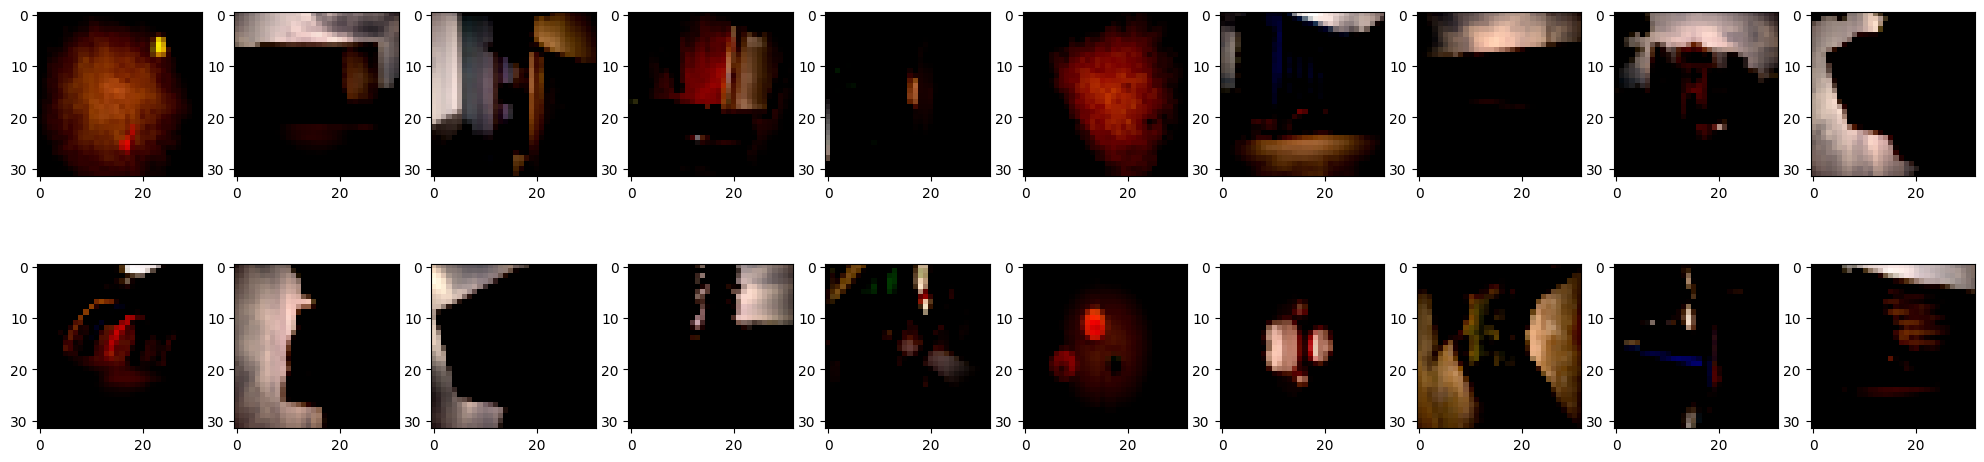

In [62]:
from matplotlib import pyplot as plt

# Set up the figure and axes
fig, axes = plt.subplots(2, 10, figsize=(25, 6))

# Plot the first 10 images from the training set
for i, ax in enumerate(axes.flat[:20]):
    image = train_set[i]  # train_set[i] returns a tuple (image, label)
    ax.imshow(image.permute(1, 2, 0))  # Permute the image to match the (H, W, C) format expected by imshow
    ax.axis('on')

plt.show()


## De-Normalized Images

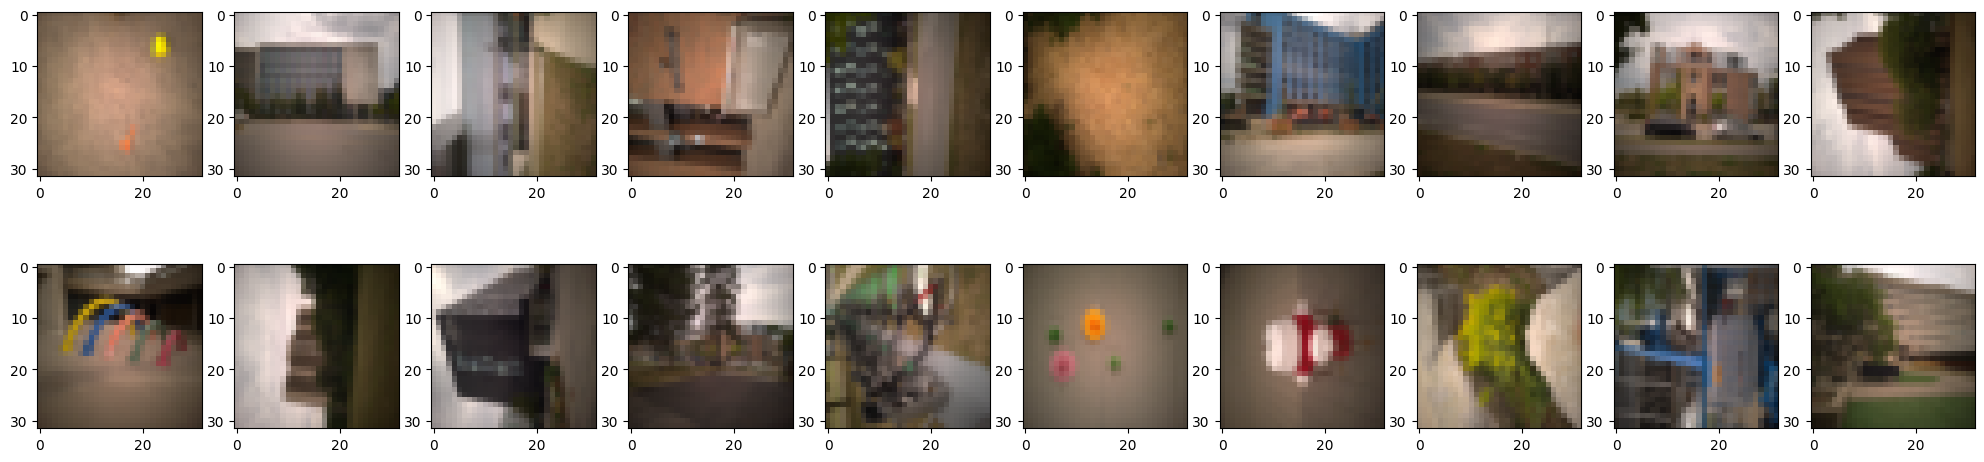

In [64]:
from matplotlib import pyplot as plt
import numpy as np

# Function to denormalize the image
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Define the mean and std used in normalization
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

# Set up the figure and axes
fig, axes = plt.subplots(2, 10, figsize=(25, 6))

for image, ax in enumerate(axes.flat[:20]):
    image = train_set[image]
    image = denormalize(image.clone(), mean, std)
    image = image.permute(1, 2, 0).numpy()
    ax.imshow(image)
    ax.axis('on')
    
plt.show()


In [9]:
from collections import OrderedDict

import torch
import torch.nn as nn


class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [14]:
def mypsnr(img1, img2):
    mse = torch.mean(((img1 * 255.0).floor() - (img2 * 255.0).floor()) ** 2, dim=[1, 2, 3])
    #    mse[(mse==0).nonzero()]=0.05  # deprecated warning after pytorch 1.5
    mse[torch.nonzero((mse == 0), as_tuple=True)] = 0.05
    psnrout = torch.mean(20 * torch.log10(255.0 / torch.sqrt(mse)))
    return psnrout

milestones = [100, 150, 200]
for i in range(len(milestones)):
    milestones[i] = int(milestones[i])

image_datasets = {'train': train_set, 'val': val_set, 'test': test_set}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels=3, out_channels=3, init_features=32)
model = model.to(device)

criterion = nn.MSELoss()

params = model.parameters()
optimizer = torch.optim.Adam(params, lr=0.001)

scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

# Starting the training process
since = time.time()

epoch_loss = {x: 0.0 for x in ['train', 'val']}
epoch_psnr = {x: 0.0 for x in ['train', 'val']}

best_loss = 10 ** 6
best_psnr = 0.0

num_epochs = 200
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 30)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()  # Set model to evaluate mode

        running_loss = 0.0
        running_psnr = 0.0

        # Iterate over data.
        for i, (inputs, targets) in enumerate(dataloaders[phase]):

            inputs = inputs.to(device)
            targets = targets.to(device)

            # Convert the tensor back to image
            # inv_transform = transforms.ToPILImage()
            # img_back = inv_transform(inputs)

            # nosiy_images = noisy_image(img_back)

            # img_pil = Image.fromarray(nosiy_images)
            # nosiy_images = transform(img_pil)

            inputs_np = inputs.permute(0, 2, 3, 1).cpu().numpy()  # (N, H, W, C)
            noisy_images = np.array([noisy_image(img) for img in inputs_np])
            noisy_images = torch.tensor(noisy_images).permute(0, 3, 1, 2).float().to(device)  # (N, C, H, W)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(noisy_images)
                loss = criterion(outputs, inputs)
                psnr = mypsnr(outputs, inputs)
                # loss = criterion(outputs, targets)
                # psnr = mypsnr(outputs, targets)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_psnr += psnr.item() * inputs.size(0)

        epoch_loss[phase] = running_loss / dataset_sizes[phase]
        epoch_psnr[phase] = running_psnr / dataset_sizes[phase]

        print('{} Loss: {:.4f} PSNR: {:.4f}'.format(
            phase, epoch_loss[phase], epoch_psnr[phase]))

        if phase == 'train':
            scheduler.step()

        # deep copy the model
        if phase == 'val' and epoch_loss[phase] < best_loss:
            best_loss = epoch_loss[phase]
            best_psnr = epoch_psnr[phase]
            torch.save(model.state_dict(), 'best_model.pth')

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val loss: {:4f}'.format(best_loss))
print('Best val psnr: {:4f}'.format(best_psnr))



Epoch 0/199
------------------------------
train Loss: 0.7847 PSNR: 1.2470
val Loss: 0.7448 PSNR: 1.4820
Epoch 1/199
------------------------------
train Loss: 0.7181 PSNR: 1.6078
val Loss: 0.7453 PSNR: 1.4700
Epoch 2/199
------------------------------
train Loss: 0.6906 PSNR: 1.7692
val Loss: 0.7403 PSNR: 1.4846
Epoch 3/199
------------------------------
train Loss: 0.6719 PSNR: 1.8808
val Loss: 0.7250 PSNR: 1.5619
Epoch 4/199
------------------------------
train Loss: 0.6537 PSNR: 1.9902
val Loss: 0.7047 PSNR: 1.6733
Epoch 5/199
------------------------------
train Loss: 0.6360 PSNR: 2.1084
val Loss: 0.6771 PSNR: 1.8417
Epoch 6/199
------------------------------
train Loss: 0.6199 PSNR: 2.2193
val Loss: 0.7332 PSNR: 1.5689
Epoch 7/199
------------------------------
train Loss: 0.6057 PSNR: 2.3318
val Loss: 0.6597 PSNR: 1.9924
Epoch 8/199
------------------------------
train Loss: 0.5935 PSNR: 2.4192
val Loss: 0.6327 PSNR: 2.0973
Epoch 9/199
------------------------------
train Loss: 

KeyboardInterrupt: 

In [15]:

import os

day_folder = r'/home/sj/autoencoder/dataset/day'

# Get the list of DNG files in the folder
dng_files = [fname for fname in os.listdir(day_folder) if fname.lower().endswith('.dng')]

# Rename the DNG files
for i, dng_file in enumerate(dng_files):
    old_path = os.path.join(day_folder, dng_file)
    new_path = os.path.join(day_folder, f"{i}.dng")
    os.rename(old_path, new_path)